# Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch
Scrape Google Play data. Implement Transfer Learning to build Sentiment Classifier using the Transformers library.

In [1]:
%reload_ext watermark
%watermark -v -p numpy
print('--------------------')
%watermark -v -p pandas
print('--------------------')
%watermark -v -p torch
print('--------------------')
%watermark -v -p transformers

CPython 3.6.6
IPython 7.10.1

numpy 1.17.4
--------------------
CPython 3.6.6
IPython 7.10.1

pandas 0.25.3
--------------------
CPython 3.6.6
IPython 7.10.1

torch 1.5.0
--------------------
CPython 3.6.6
IPython 7.10.1

transformers 2.8.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import os
import transformers
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
from tqdm import tqdm
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
from google_play_scraper import Sort, reviews, app
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Scraping data
Choose some _Productivity_ apps, scrape the data, and structure for sentiment analysis.

In [5]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

In [6]:
app_infos = []

for ap in tqdm(app_packages):
    info = app(
        ap,
        lang='en',
        country='us'
    )
    del info['comments']
    app_infos.append(info)

100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


In [8]:
def print_json(json_object):
    '''
    takes json object
    returns prettier printed json object
    '''
    json_str = json.dumps(
        json_object,
        indent=2,
        sort_keys=True,
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [11]:
# Printing the first object in the json
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "com.anydo",
  "containsAds": null,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<b>\ud83c\udfc6 Editor's Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>\ud83e\udd47 \"It\u2019s A MUST HAVE PLANNER & TO DO LIST APP\" (NYTimes, USA TODAY, WSJ & Lifehacker).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n\ud83d\udcc5 Organize Your Tasks & To-Do List in Seconds\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day C

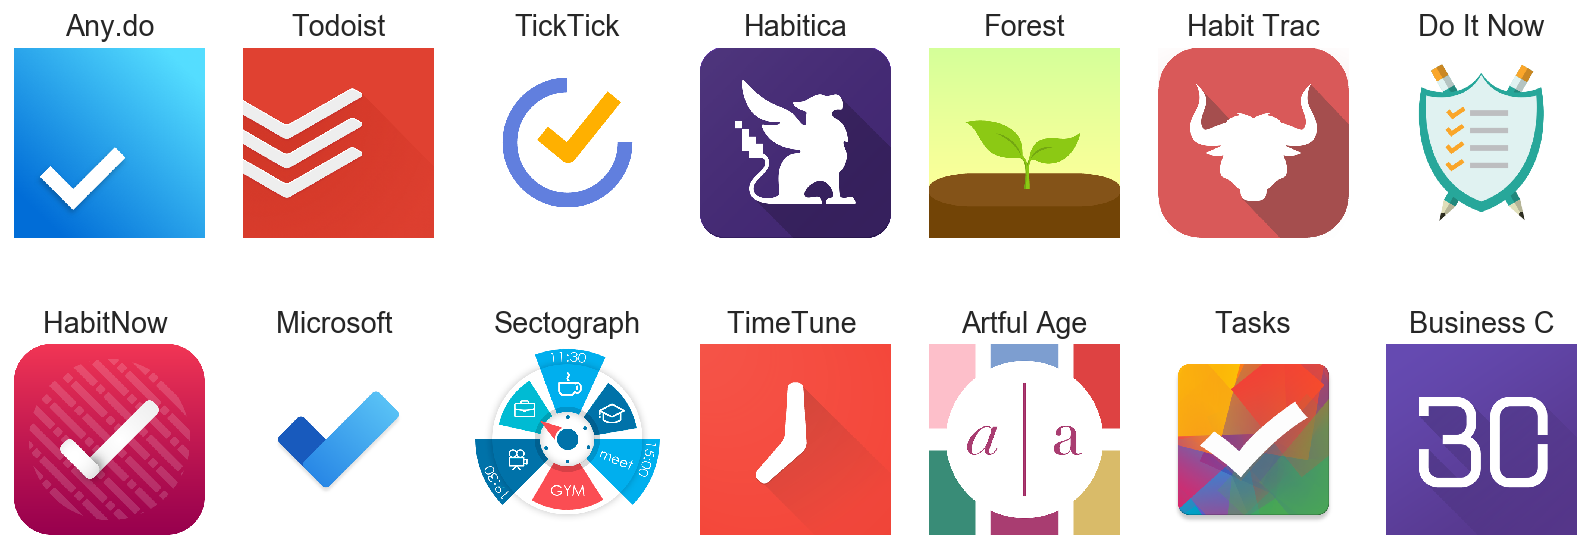

In [31]:
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

In [32]:
app_infos_df = pd.DataFrame(app_infos)

We want:
- Balanced dataset; roughly the same number of reviews for each score
- Representative sample of reviews for each app

We satify the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness but also get a subset from the newest.

In [35]:
app_reviews = []

for ap in tqdm(app_packages):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='en',
                country='us',
                sort=sort_order,
                count=200 if score == 3 else 100,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            app_reviews.extend(rvs)

100%|██████████| 15/15 [01:42<00:00,  6.87s/it]


In [36]:
print_json(app_reviews[0])

{
  "appId": "com.anydo",
  "at": "2020-06-04 21:47:31",
  "content": "This is an expensive app. That being said, it's the most low-rent experience you can imagine. For example, when you create a list item and need to edit it, you're completely out of luck because that can't happen. The best you can do is delete it and type it in (again) correctly since edit is not an option. By the way, deleting an item from your list is a multi multi step process. (update: developer noted that editing was possible (though, multiple steps required), item deletes still impossible)",
  "repliedAt": "2020-06-07 03:28:30",
  "replyContent": "To delete a task, tap the X button on a completed task, or tap \u201cDelete Task\u201d at the bottom of the Task Menu. Please make sure that you are following the instructions on our Help Center at- https://support.any.do/tasks/. If you're experiencing a specific issue, please send us a bug report via your app Settings - Support, we will be happy to assist.",
  "revie

In [40]:
print('Number of app reviews we acquired: {}'.format(len(app_reviews)))

Number of app reviews we acquired: 15960


In [42]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv(os.path.basename('reviews.csv'), index=None, header=True)

In [5]:
# load reviews dataset
df = pd.read_csv(os.path.basename('reviews.csv'))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGt2KEhc-yNMmOBsXqfHKLGJ-vDENQPVPlGZIM...,Earl Clark,https://lh3.googleusercontent.com/a-/AOh14Gj_X...,"This is an expensive app. That being said, it'...",1,155,5.1.1.13,2020-06-04 21:47:31,"To delete a task, tap the X button on a comple...",2020-06-07 03:28:30,most_relevant,com.anydo
1,gp:AOqpTOEQDt031aIrD9lHAGpY0GI9uPyfeS-onIjfdkF...,Jason Olson,https://lh3.googleusercontent.com/a-/AOh14GhUD...,Please add Shopping List widget or add a tab t...,1,5,5.1.1.13,2020-06-05 12:00:04,NaN,NaN,most_relevant,com.anydo
2,gp:AOqpTOHuZQkkDNAmNUpwfdnQSjZtvvwFoWVyPf5rWPk...,G Irish,https://lh3.googleusercontent.com/a-/AOh14Gjwg...,This last update has brought all kinds of bugs...,1,21,5.1.1.13,2020-05-22 21:40:48,Sorry about that! We are unaware of any issues...,2020-05-24 04:04:09,most_relevant,com.anydo
3,gp:AOqpTOENSETZVCAj3t-TMO9ZBmlqOLB9ujgQYdHbnj9...,Mohit Singla,https://lh3.googleusercontent.com/a-/AOh14GiJ0...,I have set daily reminders. It doesn't show th...,1,2,5.1.1.13,2020-05-28 23:05:47,The way Recurring Reminders work is that you n...,2020-05-31 05:23:29,most_relevant,com.anydo
4,gp:AOqpTOF_OBDJpMDUE3xGa8fbyCJDD3mM8z5AGNSIf4q...,Dominic Flanagan,https://lh3.googleusercontent.com/a-/AOh14Gjk1...,Pretty basic for the price. Lacks customisatio...,1,10,5.1.1.13,2020-05-28 12:23:37,Be advised that Any.do is a minimalistic task ...,2020-05-31 05:01:09,most_relevant,com.anydo


We'll study the shape of the dataset, look for missing values in score and review content, and see if class imbalance exists.

In [6]:
df.shape

(15960, 12)

In [7]:
# look for missing values in score and review content
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15960 entries, 0 to 15959
Data columns (total 12 columns):
reviewId                15960 non-null object
userName                15960 non-null object
userImage               15960 non-null object
content                 15960 non-null object
score                   15960 non-null int64
thumbsUpCount           15960 non-null int64
reviewCreatedVersion    13708 non-null object
at                      15960 non-null object
replyContent            7810 non-null object
repliedAt               7810 non-null object
sortOrder               15960 non-null object
appId                   15960 non-null object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


Text(0.5, 0, 'review score')

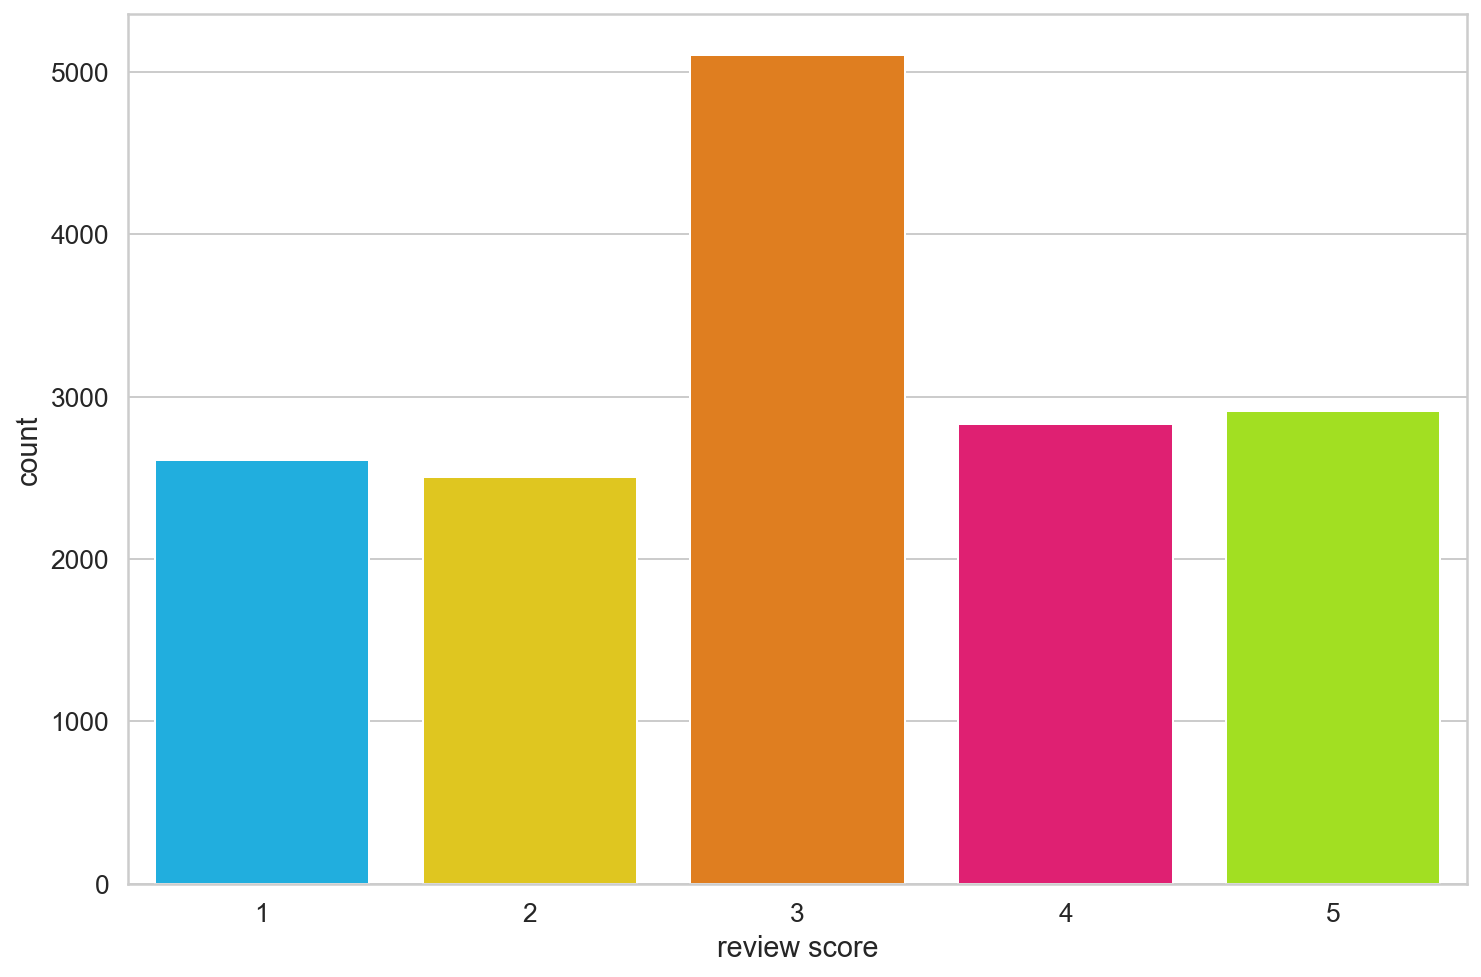

In [8]:
# look for class imbalance
sns.countplot(df.score)
plt.xlabel('review score')

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

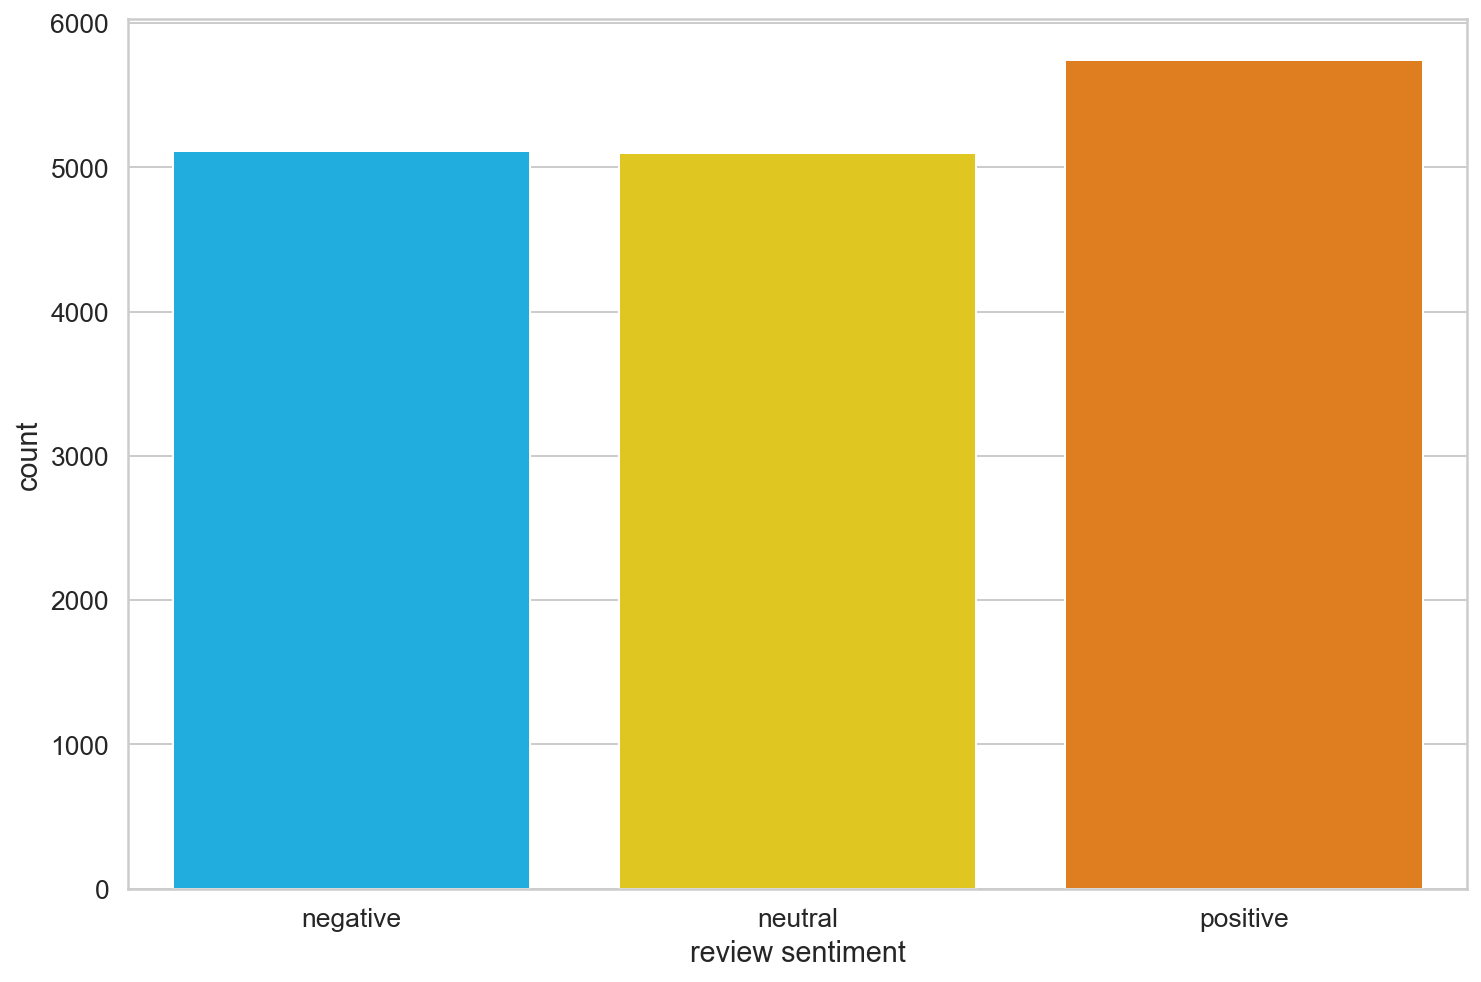

In [9]:
# convert into negative, neutral, and positive sentiment
def to_sentiment(rating):
    '''
    takes series of scores
    returns series with values less than 3 as negative, 3 as neutral, and greater than 3 as positive
    '''
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
    
df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing
Requirements for BERT to work:
- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called _attention mask_.

The transformers library provides a wide variety of transformer models (including BERT). It also includes prebuilt tokenizers that do the heavy lifting. We will be using the cased version of BERT and tokenizer.

In [10]:
# load a pre-trained BertTokenizer
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Understanding and visualizing the tokenization process.

In [14]:
sample_txt = 'When was I last outside? I have been stuck at home for 1 month.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [20]:
print(f'Sentence: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: When was I last outside? I have been stuck at home for 1 month.
Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'have', 'been', 'stuck', 'at', 'home', 'for', '1', 'month', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1138, 1151, 5342, 1120, 1313, 1111, 122, 2370, 119]


Special tokens:
- [SEP] marker for ending sentences
- [CLS] must add this token to the start of each sentence so BERT knows that we're doing classification
- [UNK] encode everything not in the training set with this as BERT already understands tokens in the training set

In [21]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [22]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [23]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [24]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [25]:
# encode_plus() method handles all of the above special token work
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [33]:
# token ids
print(len(encoding['input_ids'][0]))
encoding['input_ids']

32


tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1138, 1151, 5342, 1120,
         1313, 1111,  122, 2370,  119,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [34]:
# attention mask
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [35]:
# testing inversing the tokenization
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'have',
 'been',
 'stuck',
 'at',
 'home',
 'for',
 '1',
 'month',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']